# <span style='color:red'>Project 2.  Due October 23</span>

In [5]:
from IPython.display import display, HTML
display(HTML("<style>.container { width: 90% !important; }</style>"))

In [6]:
import csv
import sys
import scipy.io
import numpy as np
import pandas as pd
import math
import datetime
import time
import matplotlib.pyplot as plt
%matplotlib inline

##### We will have data involving $n$ assets, and use the first $T$ days of the data to compute the portfolio.
##### The computation will produce a weight $x_i$ for each asset $i = 1,...,n$, which could be long or short.
##### We assume that on each day, a position is taken at the open, and closed at noon.  So we define:
$$ p^o_{j,t} = \ \text{price of asset $j$ on day $t$ at the open}$$
$$ p^1_{j,t} = \ \text{price of asset $j$ on day $t$ at noon}$$
$$ r_{j,t} =  \ \frac{p^1_{j,t} - p^o_{j,t}}{p^o_{j,t}} = \ \text{return earned by asset $j$ on day $t$.}$$
$$ \bar r_j = \ \frac{1}{T} \sum_{t = 1}^T r_{j,t} = \ \text{average return earned by asset $j$.}$$

### In this project we develop a first-order algorithm to construct a portfolio using intraday data.

#### The optimization problem to solve depends on two parameters: $\theta \ge 0$ and $\pi > 0$.
####
$$ \text{minimize} \ \left(-\sum_{j = 1}^n \bar r_j x_j\right) \ + \ \theta \left( \frac{1}{T} \sum_{t = 1}^{T}\left[\sum_{j = 1}^n (r_{j,t} -  \bar r_j)x_j\right]^\pi\right)^{1/\pi}$$
#### 
#### There are no constraints on the quantities $x_j$.
#### The first sum is minus the average return earned by the portfolio.  In the second sum, the quantity inside the square brackets is the excess return earned by the portfolio on day $t$, magnified by the power $\pi$.  The quantity $\theta$ is a risk aversion parameter.
 

## prepare data

In [7]:
# extract close prices for open & noon
def extract_price_open_noon(stock):
    filename = f"../data/intraday/{stock}.csv"
    df = pd.read_csv(filename, low_memory=False) # use pd.read_csv because need to use datetime
    df = df.iloc[3:, :].reset_index(drop=True) # remove headers, reset index
    numactual = df.iloc[:, 2].astype(float).isna().argmax() 
    df = df.iloc[:numactual, [0,2]] # only read valid data

    df.loc[0,"BarTp"] = df.loc[1,"BarTp"].replace("31", "30") # handle "#NAME" at the beginning
    df["BarTp"] = pd.to_datetime(df["BarTp"]).apply(lambda x: datetime.datetime.strftime(x, "%Y-%m-%d %H:%M:%S")) # convert datetime to str
    dates_list = np.unique(df["BarTp"].apply(lambda x: x[:10])) # list of all dates
    
    # select open and noon for each day, throw out dates with missing values
    dfs = []
    for date in dates_list: 
        df_date = df.loc[(df["BarTp"]==date+" 09:30:00") | (df["BarTp"]==date+" 12:00:00")]
        if len( df_date )==2: 
            dfs.append(df_date)
        else:
            print(stock, date, len(df_date))
            continue
    df2 = pd.concat(dfs, axis=0).reset_index(drop=True)
    return df2

def compute_ret_from_price(price):
    return (price[:,1]-price[:,0])/price[:,0]

def get_ret_full(stock_lst):
    # select_common_dates
    df_lst = [extract_price_open_noon(stock) for stock in stock_lst]
    from functools import reduce
    df_common = reduce(lambda x,y: pd.merge(x,y, on='BarTp', how='inner'), df_lst)
    df_common.columns=['BarTp']+stock_lst
    df_common.set_index('BarTp', inplace=True)
    # compute ret from price
    prices = df_common.astype(float).values
    ret_full = np.vstack([compute_ret_from_price(prices[:,j].reshape(-1,2)) for j in range(len(stock_lst))])
    return ret_full.transpose()

In [8]:
%%time
ret_full = get_ret_full(['AMZN','NFLX','TSLA'])

AMZN 2021-04-20 1
AMZN 2021-06-14 1
CPU times: user 5.25 s, sys: 126 ms, total: 5.38 s
Wall time: 5.39 s


In [9]:
ret_full.shape

(111, 3)

In [10]:
ret_bar = np.mean(ret_full[:100, :], axis=0)
ret_bar

array([-0.00025796, -0.00034732, -0.00192305])

### <span style='color:red'> Task 1. Develop a first-order method to address this computational problem.</span>
#### Your method should work with values of $T$ at least $100$. Use the data we provide for AMZN, NFLX, TSLA, i.e., $n = 3$. 
#### Make sure your code works with $\pi = 0.5, 2, 4, 6$, and $\theta = 0.1, 10, 1000, 10^5, 10^6$.

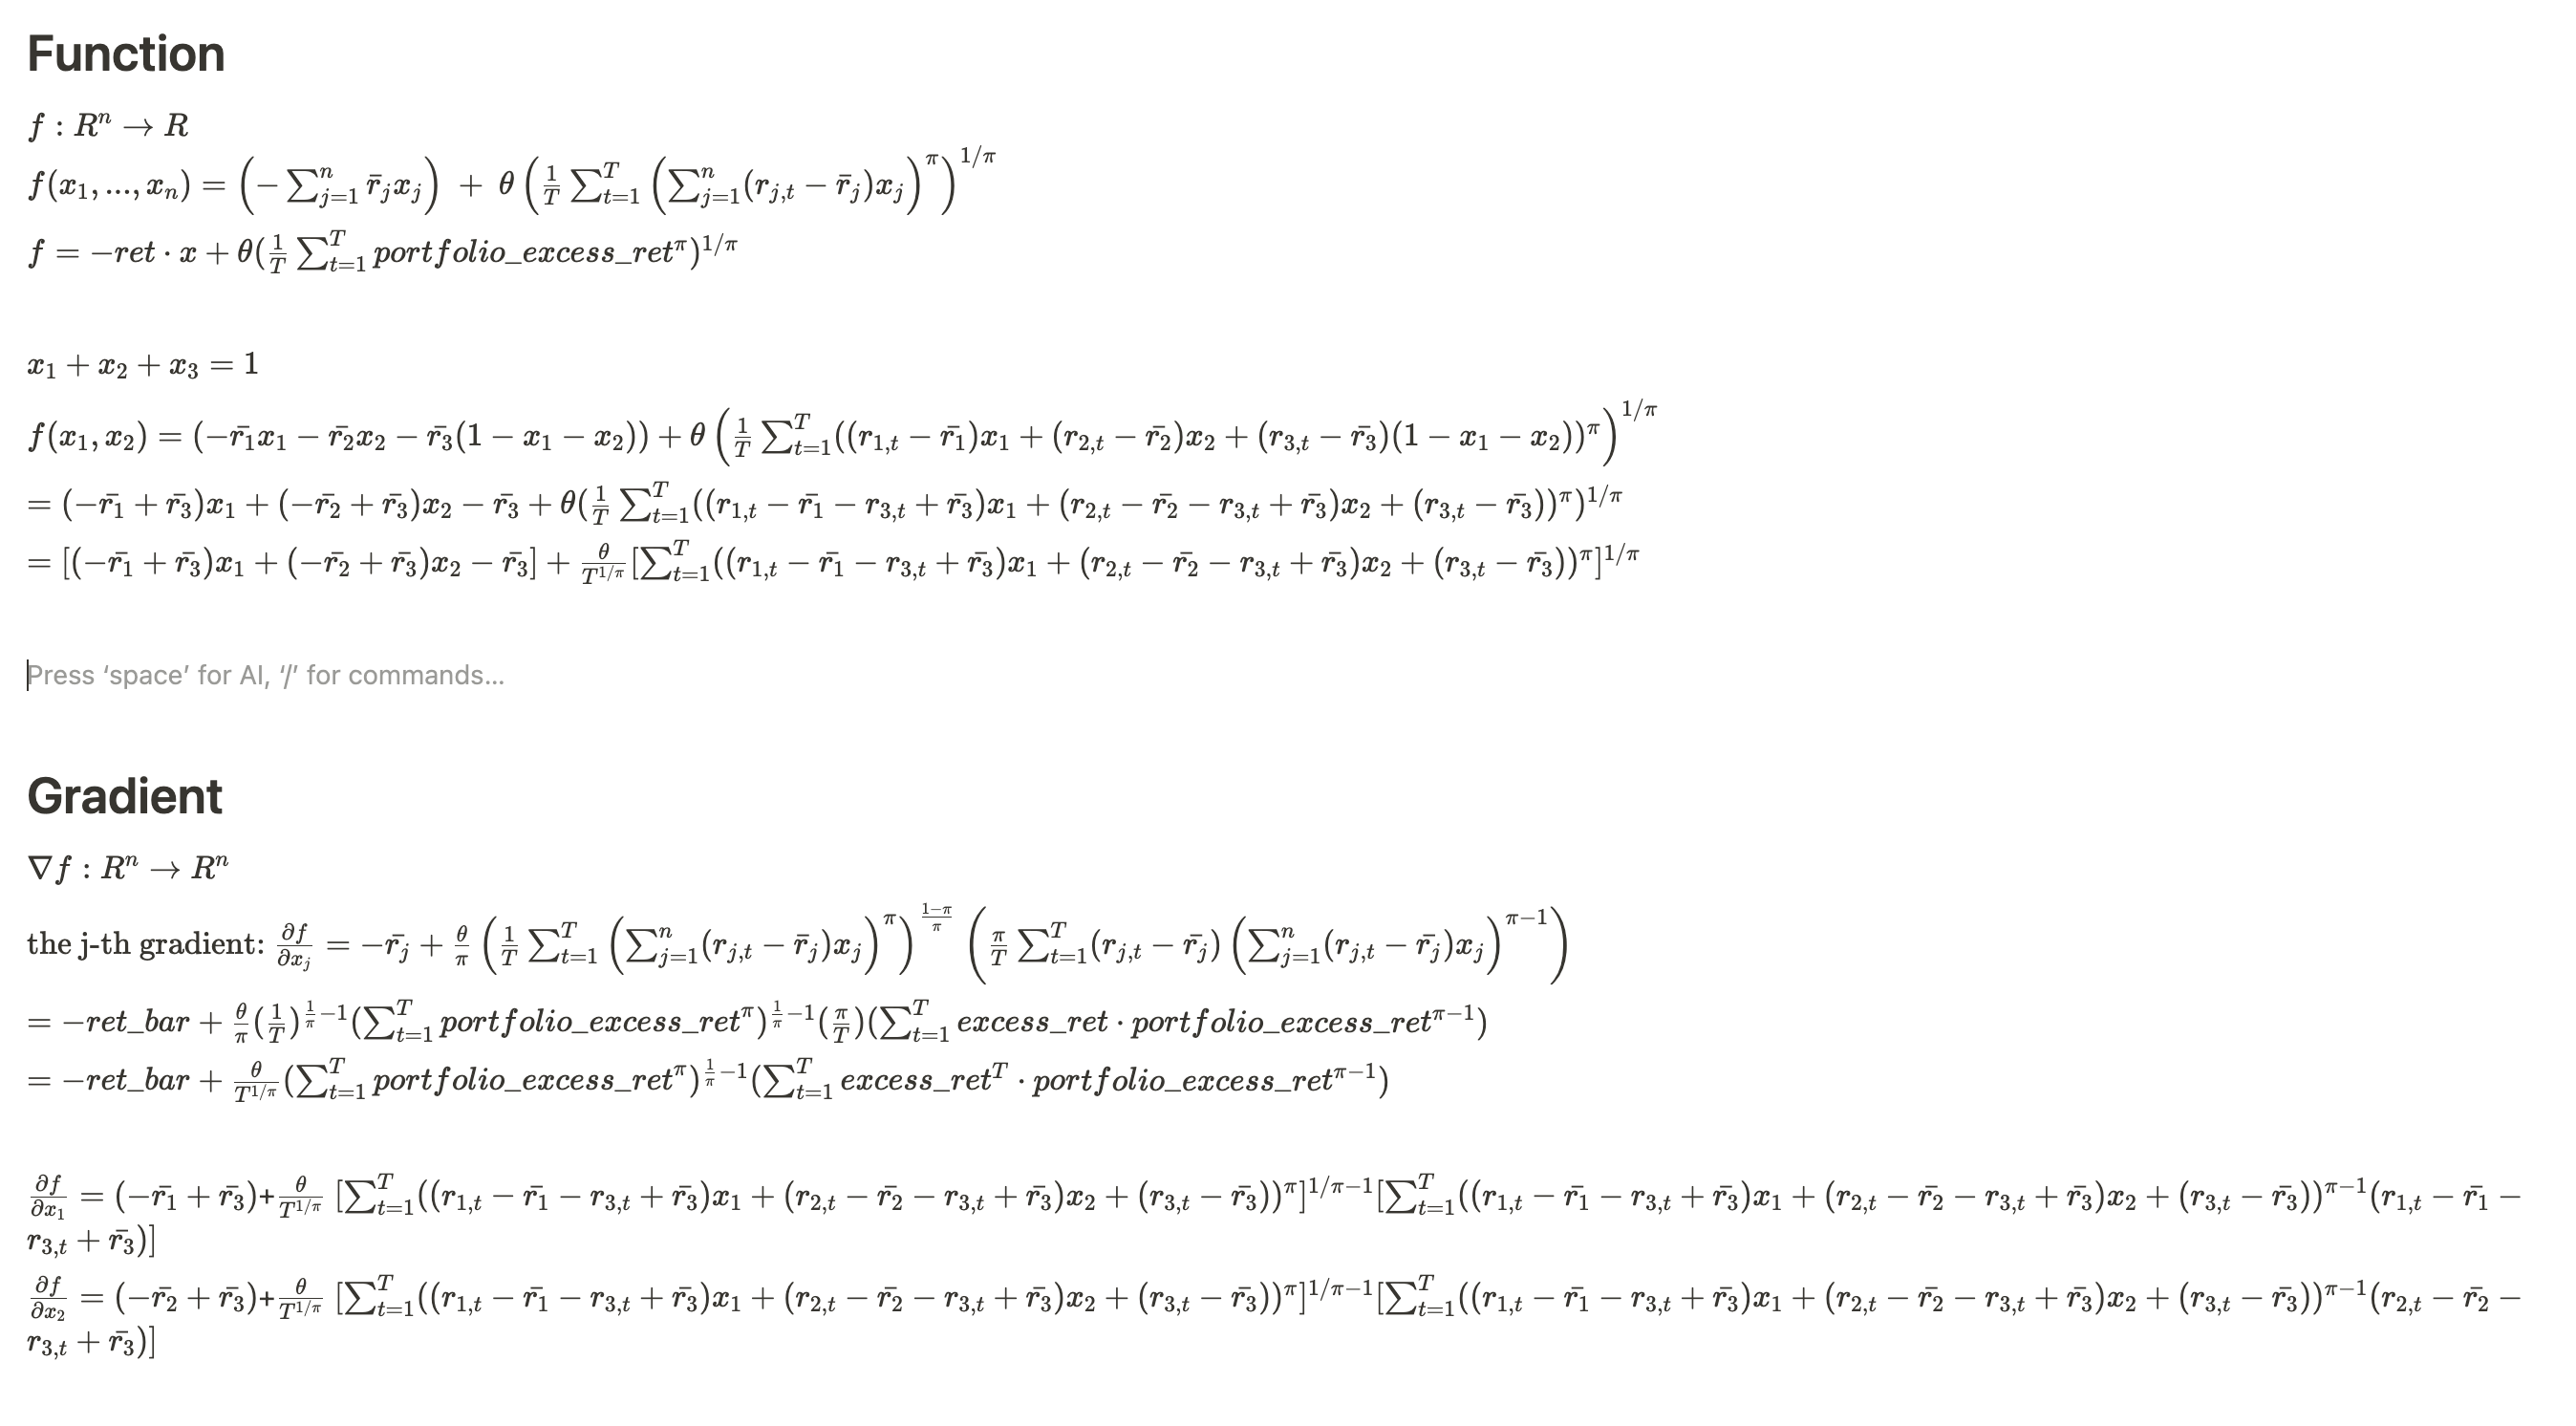

In [11]:
def eval_func(theta, pi, ret, x):
    # ret: (T,3), x: (3,)
    ret_bar = np.mean(ret, axis=0) # ret_bar: (3,)
    excess_ret = ret-ret_bar # excess_ret: (T,3)
    portfolio_excess_ret = excess_ret.dot(x) # portfolio_excess_ret: (T,)
    
    f1 = -ret_bar.dot(x)
    f2 = theta*np.mean(portfolio_excess_ret**pi)**(1/pi)
    return f1+f2

def eval_func_2d(theta, pi, ret, x):
    # ret: (T,3), x: (2,)
    ret_bar = np.mean(ret, axis=0) # ret_bar: (3,)
    excess_ret = ret-ret_bar # excess_ret: (T,3)
    
    f1 = np.array([-ret_bar[0]+ret_bar[2], -ret_bar[1]+ret_bar[2]]).dot(x)-ret_bar[2]
    f2 = (np.vstack([excess_ret[:,0]-excess_ret[:,2], excess_ret[:,1]-excess_ret[:,2]])).T.dot(x)+excess_ret[:,2]
    f3 = np.mean(f2**pi)**(1/pi)
    return f1+theta*f3

In [12]:
def eval_grad(theta, pi, ret, x):
    # ret: (T,3)
    # x: (3,)
    ret_bar = np.mean(ret, axis=0) # ret_bar: (3,)
    excess_ret = ret-ret_bar # excess_ret: (T,3)
    portfolio_excess_ret = excess_ret.dot(x) # portfolio_excess_ret: (T,)
    
    g1 = -ret_bar 
    g2 = np.sum(portfolio_excess_ret**pi)**(1/pi-1)
    g3 = np.dot(excess_ret.T, portfolio_excess_ret**(pi-1))
    return g1+(theta/T**(1/pi))*g2*g3

def eval_grad_2d(theta, pi, ret, x):
    # ret: (T,3)
    # x: (2,)
    ret_bar = np.mean(ret, axis=0) # ret_bar: (3,)
    excess_ret = ret-ret_bar # excess_ret: (T,3)
    
    g1 = np.array([-ret_bar[0]+ret_bar[2], -ret_bar[1]+ret_bar[2]])
    f2 = (np.vstack([excess_ret[:,0]-excess_ret[:,2], excess_ret[:,1]-excess_ret[:,2]])).T.dot(x)+excess_ret[:,2]
    g2 = np.sum(f2**pi)**(1/pi-1)
    g3 = (f2**(pi-1)).dot(np.vstack([excess_ret[:,0]-excess_ret[:,2], excess_ret[:,1]-excess_ret[:,2]]).T)
    return g1+(theta/T**(1/pi))*g2*g3

In [13]:
T = 100
theta = 10
pi = 2
np.random.seed(123)
ret_randn = np.random.randn(T,3)

ret_bar = np.mean(ret_randn, axis=0) # ret_bar: (3,)
excess_ret = ret_randn-ret_bar # excess_ret: (T,3)

In [14]:
eval_func(10, 2, ret_randn, np.array([1/3]*3)), eval_func_2d(10, 2, ret_randn, np.array([1/3]*2))

(6.06483137912447, 6.064831379124471)

In [15]:
eval_grad(10, 2, ret_randn, np.array([1/3]*3)), eval_grad_2d(10, 2, ret_randn, np.array([1/3]*2))

(array([4.62698217, 7.8894494 , 5.67806256]),
 array([-1.05108039,  2.21138684]))

In [16]:
def eval_func_2d_abs(theta, pi, ret, x):
    # ret: (T,3), x: (2,)
    ret_bar = np.mean(ret, axis=0) # ret_bar: (3,)
    excess_ret = ret-ret_bar # excess_ret: (T,3)
    
    f1 = np.array([-ret_bar[0]+ret_bar[2], -ret_bar[1]+ret_bar[2]]).dot(x)-ret_bar[2]
    f2 = (np.vstack([excess_ret[:,0]-excess_ret[:,2], excess_ret[:,1]-excess_ret[:,2]])).T.dot(x)+excess_ret[:,2]
    f2 = np.abs(f2)
    
    f3 = np.mean(f2**pi)**(1/pi)
    return f1+theta*f3

In [26]:
def eval_grad_2d_abs(theta, pi, ret, x):
    # ret: (T,3)
    # x: (2,)
    ret_bar = np.mean(ret, axis=0) # ret_bar: (3,)
    excess_ret = ret-ret_bar # excess_ret: (T,3)
    
    g1 = np.array([-ret_bar[0]+ret_bar[2], -ret_bar[1]+ret_bar[2]])
    f2 = (np.vstack([excess_ret[:,0]-excess_ret[:,2], excess_ret[:,1]-excess_ret[:,2]])).T.dot(x)+excess_ret[:,2]
    
    idx_neg = np.where(f2<0)[0]
        
    f2 = np.abs(f2)
    g2 = np.sum(f2**pi)**(1/pi-1)
    x = np.vstack([excess_ret[:,0]-excess_ret[:,2], excess_ret[:,1]-excess_ret[:,2]]).T
    x[idx_neg] = -x[idx_neg]
    g3 = (f2**(pi-1)).dot(x)
    
    return g1+(theta/T**(1/pi))*g2*g3

In [29]:
eval_func_2d_abs(10, 2, ret_randn, np.array([1/3]*2)), eval_grad_2d_abs(10, 2, ret_randn, np.array([1/3]*2))

(6.064831379124471, array([-1.05108039,  2.21138684]))

In [28]:
eval_func_2d_abs(10, 1/2, ret_randn, np.array([1/3]*2)), eval_grad_2d_abs(10, 1/2, ret_randn, np.array([1/3]*2))

(4.23600492172974, array([ 3.14762047, -1.83062721]))

## backtrack

In [115]:
def backtrack(theta, pi, ret, x, fval, grad, delta): 
    alpha = 0.5
    beta = 0.75
    gradtimesdelta = grad.dot(delta)
    t = 1 
    goon = True
    success = False
    while goon:
        xnew = x+t*delta
        fnew = eval_func_2d(theta, pi, ret, xnew)
        target = alpha*t*gradtimesdelta 
        if fnew - fval <= target: #target means the difference that is acceptable between fnew and fval
            goon = False
            success = True #accept if small enough
        else:
            t = beta*t
        if t < 1e-6: #1e-4:
            if fnew < fval:
                print('well, we will take it\n')  # accept if t is small enough that will not make much progress
                success = True
            goon = False
    return t, success

In [116]:
def run_backtrack(theta, pi, ret, x, N):
    xsol = np.zeros((N, len(x)))
    fvalsol = np.zeros(N)
    
    converged = False
    
    for iteration in range(N):
        xsol[iteration, :] = x
        fval = eval_func_2d(theta, pi, ret, x)
        fvalsol[iteration] = fval
        grad = eval_grad_2d(theta, pi, ret, x)
        
        delta = -grad  #this is what makes it unconstrained

        t, goodstep = backtrack(theta, pi, ret, x, fval, grad, delta)
        
        if goodstep:
            xnew = x+t*delta
            fnew = eval_func_2d(theta, pi, ret, xnew)
            x = xnew
            if np.isclose(grad, 0).all(): # g==0
                converged = True
                break
            
    print(f"\n*** Done at iteration {iteration}, converged {converged} with final grad={np.array2string(grad,precision=20)}, and t={t}, xnew={np.array2string(xnew,precision=20)}, fnew={fnew}\n")
    
    return iteration, xsol, fvalsol, xnew, fnew, grad, converged

In [117]:
theta = 10
pi = 2
N = 5000

x = np.array([1/3, 1/3])
T = 100
ret = ret_full[:T,:]
ret.shape

(100, 3)

In [118]:
iteration, xsol, fvalsol, xnew, fnew, grad, converged = run_backtrack(theta, pi, ret, x, N)


*** Done at iteration 232, converged True with final grad=[-9.860010124346230e-09  9.174532269963162e-09], and t=1, xnew=[0.7522351499706647  0.32162669776352154], fnew=0.08659522258699945



In [112]:
np.append(xnew, [1-xnew.sum()]), fnew

(array([ 0.75223515,  0.3216267 , -0.07386185]), 0.08659522258699945)

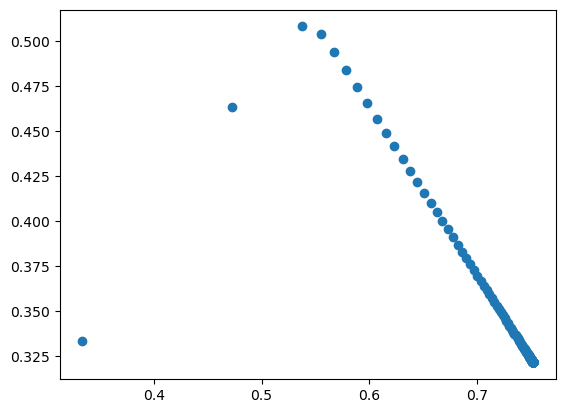

In [113]:
plt.scatter(xsol[:iteration+1,0], xsol[:iteration+1,1])

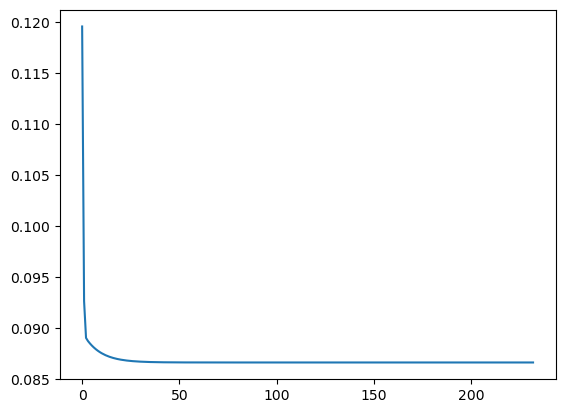

In [114]:
plt.plot(fvalsol[:iteration+1])

## momentum

### <span style='color:red'>Task 2: Benchmark your portfolio on the remaining days</span>
#### On each of the remaining days, we proceed as follows.  Denote by $x^*$ your portfolio. At the market open we invest $10^9 x^*_j$ on each asset $j$, and we close the position (by) noon.  You need to use the asset's price to compute the number of shares that you invest in, whether long or short. So the total you invest equals $$ \sum_{j = 1}^n 10^9 |x^*_j|.$$
#### Report the average return earned by your portfolio.